In [1]:
import pandas as pd
import matplotlib.pyplot as plt


## Loading of the dataset

In [2]:
data=pd.read_csv("personalized_medication_dataset.csv",sep=",")
df=pd.read_csv("personalized_medication_dataset.csv",sep=",")
data.head()

,Patient_ID,Age,Gender,Weight_kg,Height_cm,BMI,Chronic_Conditions,Drug_Allergies,Genetic_Disorders,Diagnosis,Symptoms,Recommended_Medication,Dosage,Duration,Treatment_Effectiveness,Adverse_Reactions,Recovery_Time_Days
0,P0001,78,Other,88.7,196.3,21.1,NaN,Penicillin,Cystic Fibrosis,Inflammation,Fever,Amlodipine,NaN,30 days,Effective,Yes,18
1,P0002,57,Female,90.5,195.6,30.2,Hypertension,NaN,Cystic Fibrosis,Depression,"Fatigue, Headache, Dizziness",Amoxicillin,5 mg,NaN,Neutral,No,24
2,P0003,29,Female,87.0,168.2,27.0,NaN,Sulfa,NaN,Inflammation,"Joint Pain, Headache, Nausea",NaN,NaN,7 days,Effective,Yes,12
3,P0004,56,Female,81.4,188.9,26.9,Hypertension,Penicillin,Cystic Fibrosis,Infection,Joint Pain,Ibuprofen,200 mg,7 days,Very Effective,No,22
4,P0005,90,Male,64.2,157.0,33.3,NaN,Sulfa,Sickle Cell Anemia,Inflammation,"Fatigue, Fever, Headache",Amlodipine,500 mg,10 days,Ineffective,Yes,25


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Patient_ID               1000 non-null   object 
 1   Age                      1000 non-null   int64  
 2   Gender                   1000 non-null   object 
 3   Weight_kg                1000 non-null   float64
 4   Height_cm                1000 non-null   float64
 5   BMI                      1000 non-null   float64
 6   Chronic_Conditions       754 non-null    object 
 7   Drug_Allergies           676 non-null    object 
 8   Genetic_Disorders        661 non-null    object 
 9   Diagnosis                1000 non-null   object 
 10  Symptoms                 1000 non-null   object 
 11  Recommended_Medication   737 non-null    object 
 12  Dosage                   805 non-null    object 
 13  Duration                 743 non-null    object 
 14  Treatment_Effectiveness  

In [4]:
data.shape

(1000, 17)

In [5]:
data.describe()

,Age,Weight_kg,Height_cm,BMI,Recovery_Time_Days
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,53.620000,84.337000,175.264800,26.442100,16.272000
std,21.111402,20.403463,14.812709,4.741899,8.108623
min,18.000000,50.000000,150.000000,18.500000,3.000000
25%,34.000000,66.200000,162.575000,22.200000,9.000000
50%,52.000000,84.950000,175.200000,26.200000,16.000000
75%,72.000000,101.650000,188.300000,30.500000,24.000000
max,90.000000,119.800000,199.900000,35.000000,30.000000


In [6]:
data.columns

Index(['Patient_ID', 'Age', 'Gender', 'Weight_kg', 'Height_cm', 'BMI',
       'Chronic_Conditions', 'Drug_Allergies', 'Genetic_Disorders',
       'Diagnosis', 'Symptoms', 'Recommended_Medication', 'Dosage', 'Duration',
       'Treatment_Effectiveness', 'Adverse_Reactions', 'Recovery_Time_Days'],
      dtype='object')

## TEST 2 

In this part, we trained two supervised machine learning models: a Decision Tree and a Support Vector Machine (SVM) to predict the recommended medication.
The data was cleaned by handling missing values, and different types of features were processed using a pipeline: numerical features were scaled, categorical features were one-hot encoded, and medical text data was transformed using TF-IDF.
Both models were optimized using GridSearchCV with cross-validation and the F1-macro score.
Finally, the models were evaluated on the test set using accuracy, F1-macro, classification reports, and confusion matrices to compare their performance.

In [7]:
# PARTIE 2 – Decision Tree & SVM 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

# 1) Nettoyage de base & préparation des features


# 1.1 Replace the "None" in the target by "None" (because Jupyter read them as NaN)
data["Recommended_Medication"] = data["Recommended_Medication"].fillna("None")

# 1.2 Replace the None by "None"
text_cols = [
    "Symptoms",
    "Diagnosis",
    "Chronic_Conditions",
    "Drug_Allergies",
    "Genetic_Disorders",
]
for col in text_cols:
    data[col] = data[col].fillna("None")
    
# 1.3 Target
y = data["Recommended_Medication"]

# 1.4 Feature text combined (symptoms + diagnostic + medical context)
data["text_medical"] = (
    data["Symptoms"].astype(str) + " "
    + data["Diagnosis"].astype(str) + " "
    + data["Chronic_Conditions"].astype(str) + " "
    + data["Drug_Allergies"].astype(str) + " "
    + data["Genetic_Disorders"].astype(str)
)

# 1.5 Selection of explicative feature 
feature_cols = [
    "Age",
    "Weight_kg",
    "Height_cm",
    "BMI",
    "Gender",
    "text_medical",
]

X = data[feature_cols].copy()

print("Shape X:", X.shape)
print("Classes cibles:", y.unique())


# 2) Train / Test split 

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y,
)

print("Taille train:", X_train.shape, " | Taille test:", X_test.shape)


# 3) Preprocessing : num + cat + text (TF-IDF)


numeric_features = ["Age", "Weight_kg", "Height_cm", "BMI"]
categorical_features = ["Gender"]
text_feature = "text_medical"

numeric_transformer = Pipeline(
    steps=[
        ("scaler", StandardScaler())
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ]
)

text_transformer = Pipeline(
    steps=[
        ("tfidf", TfidfVectorizer(
            max_features=1000,     
            stop_words="english",
            ngram_range=(1, 2),
        ))
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
        ("txt", text_transformer, text_feature),
    ]
)


# 4) DECISION TREE + GRIDSEARCHCV

dt_clf = DecisionTreeClassifier(random_state=42)

dt_pipeline = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("clf", dt_clf),
    ]
)

dt_param_grid = {
    "clf__criterion": ["gini", "entropy"],
    "clf__max_depth": [3, 5, 8, None],
    "clf__min_samples_split": [2, 5, 10],
    "clf__min_samples_leaf": [1, 2, 4],
}

dt_grid = GridSearchCV(
    dt_pipeline,
    param_grid=dt_param_grid,
    cv=3,
    scoring="f1_macro",   
    n_jobs=-1,
    verbose=1,
)

print("\n===== GridSearchCV for Decision Tree =====")
dt_grid.fit(X_train, y_train)

print("\n>>> Best DT params:", dt_grid.best_params_)
print(">>> Best DT CV F1-macro:", dt_grid.best_score_)

dt_best = dt_grid.best_estimator_
y_pred_dt = dt_best.predict(X_test)

dt_acc = accuracy_score(y_test, y_pred_dt)
dt_f1 = f1_score(y_test, y_pred_dt, average="macro")
dt_cm = confusion_matrix(y_test, y_pred_dt)

print("\n=== Decision Tree on Test Set ===")
print("Accuracy:", dt_acc)
print("F1-macro:", dt_f1)
print("Classification report:\n", classification_report(y_test, y_pred_dt))
print("Confusion matrix:\n", dt_cm)


# 5) SVM (SVC) + GRIDSEARCHCV


svm_clf = SVC(probability=True, random_state=42)

svm_pipeline = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("clf", svm_clf),
    ]
)

svm_param_grid = {
    "clf__C": [0.1, 1, 10],
    "clf__kernel": ["linear", "rbf"],
    "clf__gamma": ["scale", "auto"],
}

svm_grid = GridSearchCV(
    svm_pipeline,
    param_grid=svm_param_grid,
    cv=3,
    scoring="f1_macro",
    n_jobs=-1,
    verbose=1,
)

print("\n===== GridSearchCV for SVM =====")
svm_grid.fit(X_train, y_train)

print("\n>>> Best SVM params:", svm_grid.best_params_)
print(">>> Best SVM CV F1-macro:", svm_grid.best_score_)

svm_best = svm_grid.best_estimator_
y_pred_svm = svm_best.predict(X_test)

svm_acc = accuracy_score(y_test, y_pred_svm)
svm_f1 = f1_score(y_test, y_pred_svm, average="macro")
svm_cm = confusion_matrix(y_test, y_pred_svm)

print("\n=== SVM on Test Set ===")
print("Accuracy:", svm_acc)
print("F1-macro:", svm_f1)
print("Classification report:\n", classification_report(y_test, y_pred_svm))
print("Confusion matrix:\n", svm_cm)

# 6) RÉSUMÉ COMPARATIF

print("\n===== COMPARISON SUMMARY =====")
print(f"Decision Tree -> Acc: {dt_acc:.3f}, F1-macro: {dt_f1:.3f}")
print(f"SVM           -> Acc: {svm_acc:.3f}, F1-macro: {svm_f1:.3f}")


Shape X: (1000, 6)
Classes cibles: ['Amlodipine' 'Amoxicillin' 'None' 'Ibuprofen']
Taille train: (800, 6)  | Taille test: (200, 6)

===== GridSearchCV for Decision Tree =====
Fitting 3 folds for each of 72 candidates, totalling 216 fits

>>> Best DT params: {'clf__criterion': 'entropy', 'clf__max_depth': None, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 2}
>>> Best DT CV F1-macro: 0.2592951374059473

=== Decision Tree on Test Set ===
Accuracy: 0.28
F1-macro: 0.2797410192147034
Classification report:
               precision    recall  f1-score   support

  Amlodipine       0.28      0.37      0.32        49
 Amoxicillin       0.22      0.24      0.23        51
   Ibuprofen       0.31      0.27      0.29        48
        None       0.33      0.25      0.29        52

    accuracy                           0.28       200
   macro avg       0.29      0.28      0.28       200
weighted avg       0.29      0.28      0.28       200

Confusion matrix:
 [[18 14 10  7]
 [17 12 12 10]


The dataset contains 1,000 samples and four target classes. After splitting the data, 800 samples were used for training and 200 for testing.
The Decision Tree achieved an accuracy of 28% and an F1-macro score of 0.28. The model shows limited performance and struggles to clearly separate the different medication classes.
The SVM model performed slightly better, with an accuracy of 32.5% and an F1-macro score of 0.33. It provides more balanced predictions across the classes compared to the Decision Tree.
Overall, the SVM outperforms the Decision Tree on this task, but both models show relatively low performance, suggesting that the problem is complex and may require more data, better feature engineering, or more advanced models.

## TEST 3

In this part, we applied ensemble learning methods to improve the performance of the previous models.
First, Bagging was used with the best Decision Tree and SVM models found earlier. Bagging trains multiple models on different subsets of the data and combines their predictions to reduce overfitting and improve stability.
Then, a VotingClassifier was built by combining the Bagging Decision Tree and Bagging SVM using soft voting, which averages the predicted probabilities.
The models were evaluated on the test set using accuracy, F1-macro, precision, recall, and confusion matrices. We also compared inference time, model size, and interpretability.
Overall, ensemble methods provide more robust and balanced predictions compared to single models, at the cost of increased complexity and lower interpretability.


===== GridSearchCV for Bagging Decision Tree =====
Fitting 3 folds for each of 9 candidates, totalling 27 fits

>>> Best Bagging DT params: {'bag__bootstrap': True, 'bag__max_samples': 0.7, 'bag__n_estimators': 10}
>>> Best Bagging DT CV F1-macro: 0.2703054548928747

=== Bagging Decision Tree on Test Set ===
Accuracy: 0.25
F1-macro: 0.24755098371603226
Precision-macro: 0.24875915278392058
Recall-macro: 0.24933627297072675
Confusion matrix:
 [[16 16  7 10]
 [17 11  8 15]
 [12 17  8 11]
 [11 13 13 15]]

===== GridSearchCV for Bagging SVM =====
Fitting 3 folds for each of 9 candidates, totalling 27 fits


Exception ignored in: <function ResourceTracker.__del__ at 0x1050adbc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x106f9dbc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x106c65bc0>
Traceback (most recent call last


>>> Best Bagging SVM params: {'bag__bootstrap': True, 'bag__max_samples': 0.7, 'bag__n_estimators': 5}
>>> Best Bagging SVM CV F1-macro: 0.20084664401045293

=== Bagging SVM on Test Set ===
Accuracy: 0.185
F1-macro: 0.15316620991731666
Precision-macro: 0.1572420634920635
Recall-macro: 0.1803937921322375
Confusion matrix:
 [[ 3 14  3 29]
 [14 13  1 23]
 [ 8 11  1 28]
 [10 18  4 20]]

===== Training VotingClassifier (Bagging DT + Bagging SVM) =====


Exception ignored in: <function ResourceTracker.__del__ at 0x104c59bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x10663dbc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x105469bc0>
Traceback (most recent call last


=== VotingClassifier (Bagging SVM + Bagging DT) on Test Set ===
Accuracy: 0.265
F1-macro: 0.2615403437773757
Precision-macro: 0.2637611749680715
Recall-macro: 0.2638536183704251
Confusion matrix:
 [[16 16  7 10]
 [16 12  8 15]
 [12 16  8 12]
 [11 14 10 17]]


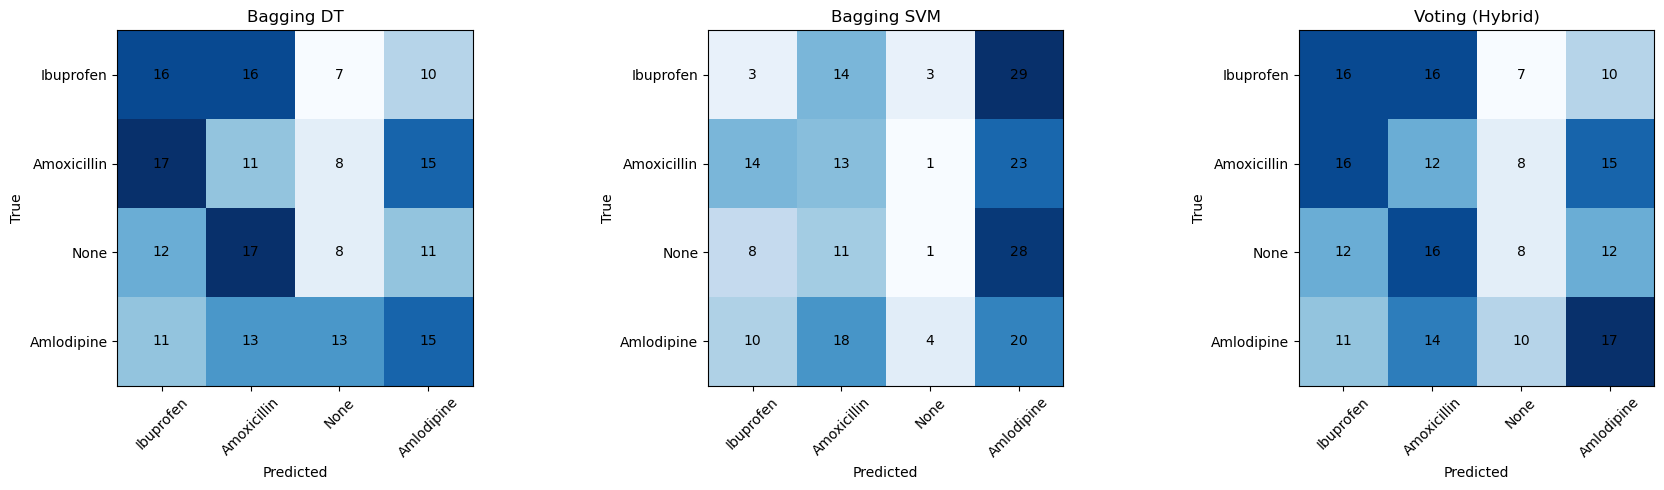

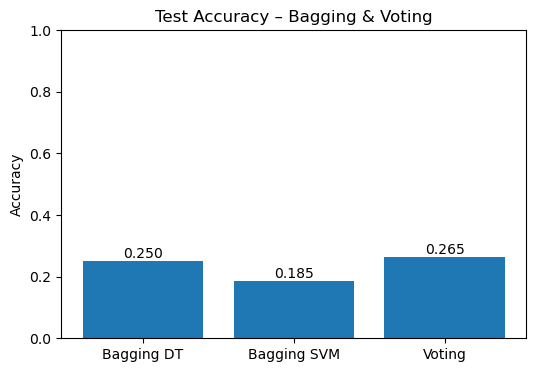


===== SUMMARY TABLE =====
             Model  Accuracy  F1_macro  Precision_macro  Recall_macro  \
0       Bagging DT     0.250  0.247551         0.248759      0.249336   
1      Bagging SVM     0.185  0.153166         0.157242      0.180394   
2  Voting (Hybrid)     0.265  0.261540         0.263761      0.263854   

   Inference_time_s                   Model_size_approx  \
0          0.016939  10 trees, depth≈25.1, leaves≈130.0   
1          0.030530                5 SVMs, avg SV≈375.2   
2          1.432675        2 ensembles (BagDT + BagSVM)   

                  Interpretability  
0       Medium (ensemble d'arbres)  
1  Low (ensemble de SVM linéaires)  
2    Low (combinaison d'ensembles)  


In [8]:
# PARTIE OPTIMIZATION – Bagging + Voting 

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import BaggingClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    confusion_matrix,
    classification_report,
)



# 1) Definition of base model (with the best founded hyperparameters)

# Decision Tree optimal found in Part 2
dt_base = DecisionTreeClassifier(
    criterion="entropy",
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=2,
    random_state=42,
)

# SVM optimal found in Part 2
svm_base = SVC(
    C=10,
    kernel="linear",
    gamma="scale",
    probability=True,
    random_state=42,
)

# 2) Bagging Decision Tree – Pipeline + GridSearchCV

from sklearn.pipeline import Pipeline

bag_dt_pipeline = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("bag", BaggingClassifier(
            estimator=dt_base,
            random_state=42,
            n_jobs=-1,
        )),
    ]
)

param_grid_bag_dt = {
    "bag__n_estimators": [10, 30, 50],
    "bag__max_samples": [0.5, 0.7, 1.0],
    "bag__bootstrap": [True],   # classique en bagging
}

print("\n===== GridSearchCV for Bagging Decision Tree =====")
bag_dt_grid = GridSearchCV(
    bag_dt_pipeline,
    param_grid=param_grid_bag_dt,
    cv=3,
    scoring="f1_macro",
    n_jobs=-1,
    verbose=1,
)

bag_dt_grid.fit(X_train, y_train)

print("\n>>> Best Bagging DT params:", bag_dt_grid.best_params_)
print(">>> Best Bagging DT CV F1-macro:", bag_dt_grid.best_score_)

bag_dt_best = bag_dt_grid.best_estimator_

t0 = time.perf_counter()
y_pred_bag_dt = bag_dt_best.predict(X_test)
dt_time = time.perf_counter() - t0

bag_dt_acc = accuracy_score(y_test, y_pred_bag_dt)
bag_dt_f1 = f1_score(y_test, y_pred_bag_dt, average="macro")
bag_dt_prec = precision_score(y_test, y_pred_bag_dt, average="macro")
bag_dt_rec = recall_score(y_test, y_pred_bag_dt, average="macro")
bag_dt_cm = confusion_matrix(y_test, y_pred_bag_dt)

print("\n=== Bagging Decision Tree on Test Set ===")
print("Accuracy:", bag_dt_acc)
print("F1-macro:", bag_dt_f1)
print("Precision-macro:", bag_dt_prec)
print("Recall-macro:", bag_dt_rec)
print("Confusion matrix:\n", bag_dt_cm)

# Approx "model size"
dt_estimators = bag_dt_best.named_steps["bag"].estimators_
dt_depths = [est.get_depth() for est in dt_estimators]
dt_leaves = [est.get_n_leaves() for est in dt_estimators]
bag_dt_model_size = f"{len(dt_estimators)} trees, depth≈{np.mean(dt_depths):.1f}, leaves≈{np.mean(dt_leaves):.1f}"


# 3) Bagging SVM – Pipeline + GridSearchCV

bag_svm_pipeline = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("bag", BaggingClassifier(
            estimator=svm_base,
            random_state=42,
            n_jobs=-1,
        )),
    ]
)

param_grid_bag_svm = {
    "bag__n_estimators": [5, 10, 20],
    "bag__max_samples": [0.5, 0.7, 1.0],
    "bag__bootstrap": [True],
}

print("\n===== GridSearchCV for Bagging SVM =====")
bag_svm_grid = GridSearchCV(
    bag_svm_pipeline,
    param_grid=param_grid_bag_svm,
    cv=3,
    scoring="f1_macro",
    n_jobs=-1,
    verbose=1,
)

bag_svm_grid.fit(X_train, y_train)

print("\n>>> Best Bagging SVM params:", bag_svm_grid.best_params_)
print(">>> Best Bagging SVM CV F1-macro:", bag_svm_grid.best_score_)

bag_svm_best = bag_svm_grid.best_estimator_

t0 = time.perf_counter()
y_pred_bag_svm = bag_svm_best.predict(X_test)
svm_time = time.perf_counter() - t0

bag_svm_acc = accuracy_score(y_test, y_pred_bag_svm)
bag_svm_f1 = f1_score(y_test, y_pred_bag_svm, average="macro")
bag_svm_prec = precision_score(y_test, y_pred_bag_svm, average="macro")
bag_svm_rec = recall_score(y_test, y_pred_bag_svm, average="macro")
bag_svm_cm = confusion_matrix(y_test, y_pred_bag_svm)

print("\n=== Bagging SVM on Test Set ===")
print("Accuracy:", bag_svm_acc)
print("F1-macro:", bag_svm_f1)
print("Precision-macro:", bag_svm_prec)
print("Recall-macro:", bag_svm_rec)
print("Confusion matrix:\n", bag_svm_cm)

# Approx "model size"
svm_estimators = bag_svm_best.named_steps["bag"].estimators_
svm_sv_counts = [est.n_support_.sum() for est in svm_estimators]
bag_svm_model_size = f"{len(svm_estimators)} SVMs, avg SV≈{np.mean(svm_sv_counts):.1f}"

# 4) VotingClassifier – Hybrid (Bagging SVM + Bagging DT)

voting_clf = VotingClassifier(
    estimators=[
        ("bag_dt", bag_dt_best),
        ("bag_svm", bag_svm_best),
    ],
    voting="soft"  # moyenne des probabilités
)

print("\n===== Training VotingClassifier (Bagging DT + Bagging SVM) =====")
voting_clf.fit(X_train, y_train)

t0 = time.perf_counter()
y_pred_voting = voting_clf.predict(X_test)
voting_time = time.perf_counter() - t0

voting_acc = accuracy_score(y_test, y_pred_voting)
voting_f1 = f1_score(y_test, y_pred_voting, average="macro")
voting_prec = precision_score(y_test, y_pred_voting, average="macro")
voting_rec = recall_score(y_test, y_pred_voting, average="macro")
voting_cm = confusion_matrix(y_test, y_pred_voting)

print("\n=== VotingClassifier (Bagging SVM + Bagging DT) on Test Set ===")
print("Accuracy:", voting_acc)
print("F1-macro:", voting_f1)
print("Precision-macro:", voting_prec)
print("Recall-macro:", voting_rec)
print("Confusion matrix:\n", voting_cm)

voting_model_size = "2 ensembles (BagDT + BagSVM)"

# 5) Visualisation of confusion matrix


fig, axes = plt.subplots(1, 3, figsize=(18, 5))

models_cm = [
    ("Bagging DT", bag_dt_cm),
    ("Bagging SVM", bag_svm_cm),
    ("Voting (Hybrid)", voting_cm),
]

classes = y_test.unique()

for ax, (title, cm) in zip(axes, models_cm):
    im = ax.imshow(cm, cmap="Blues")
    ax.set_title(title)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_xticks(range(len(classes)))
    ax.set_yticks(range(len(classes)))
    ax.set_xticklabels(classes, rotation=45)
    ax.set_yticklabels(classes)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, cm[i, j], ha="center", va="center", color="black")
plt.tight_layout()
plt.show()

# 6) Bar chart of accuracies


model_names = ["Bagging DT", "Bagging SVM", "Voting"]
accuracies = [bag_dt_acc, bag_svm_acc, voting_acc]

plt.figure(figsize=(6, 4))
plt.bar(model_names, accuracies)
plt.title("Test Accuracy – Bagging & Voting")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.01, f"{v:.3f}", ha="center")
plt.show()

# 7) summary :accuracy, F1, time, size, interpretability


summary = pd.DataFrame({
    "Model": ["Bagging DT", "Bagging SVM", "Voting (Hybrid)"],
    "Accuracy": [bag_dt_acc, bag_svm_acc, voting_acc],
    "F1_macro": [bag_dt_f1, bag_svm_f1, voting_f1],
    "Precision_macro": [bag_dt_prec, bag_svm_prec, voting_prec],
    "Recall_macro": [bag_dt_rec, bag_svm_rec, voting_rec],
    "Inference_time_s": [dt_time, svm_time, voting_time],
    "Model_size_approx": [bag_dt_model_size, bag_svm_model_size, voting_model_size],
    "Interpretability": [
        "Medium (ensemble d'arbres)",
        "Low (ensemble de SVM linéaires)",
        "Low (combinaison d'ensembles)",
    ],
})

print("\n===== SUMMARY TABLE =====")
print(summary)


The Bagging Decision Tree model achieved an accuracy of 25% and an F1-macro score of 0.25. Compared to the single Decision Tree, bagging did not improve performance and slightly reduced overall results, suggesting that the base trees may already be too complex or that the data variability is limited.
The Bagging SVM performed poorly, with an accuracy of 18.5% and an F1-macro score of 0.15. This indicates that bagging is not well suited for SVMs in this context, as SVMs are already stable models and do not benefit much from bootstrap sampling.
The Voting (Hybrid) model, which combines Bagging Decision Tree and Bagging SVM, reached an accuracy of 26.5% and an F1-macro score of 0.26. While slightly better than Bagging Decision Tree alone, it still does not outperform the standalone SVM from Part 2.
Overall, these results show that ensemble methods do not always guarantee better performance. In this case, the added complexity of Bagging and Voting increased computation time and reduced interpretability without providing significant performance gains. This suggests that further improvements may require better feature engineering, more informative text data, or different model architectures rather than more complex ensembles.